In [1]:
import numpy as np
import pandas as pd
import keras as k

from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = (10,10)
rcParams["lines.linewidth"] = 2 
plt.style.use("ggplot")

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

import warnings
warnings.filterwarnings('ignore')

In [5]:
#loading from the file
df = pd.read_csv('Bitcoin Gold.csv')
#checking the data - first and last 5
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Currency'], dtype='object')

In [6]:
df.head(20)

Date        Open        High         Low       Close       Volume  \
0   2017-11-09  140.514008  156.664993  138.231003  156.664993   13140500.0   
1   2017-11-10  157.490005  213.403000  155.391998  213.403000   36198500.0   
2   2017-11-11  213.123993  509.811005  213.123993  427.135010  187191008.0   
3   2017-11-12  421.750000  465.618011  281.545013  282.407013   90339904.0   
4   2017-11-13  277.002991  307.259003  218.339005  249.220993   45916500.0   
5   2017-11-14  253.214996  253.214996  154.052002  159.940994   39340400.0   
6   2017-11-15  160.539001  187.278000  151.466003  161.690994   30094100.0   
7   2017-11-16  161.871994  181.330002  136.395004  140.776993   27949200.0   
8   2017-11-17  138.751007  165.934998  133.048004  152.020004   24935100.0   
9   2017-11-18  153.072006  172.449997  151.787003  155.727005   24642900.0   
10  2017-11-19  154.914993  155.548004  133.962006  135.686005   19503400.0   
11  2017-11-20  135.197006  247.102005  105.788002  236.373001   93826896.0   
12  2017-11-21  250.850998  364.782990  201.895996  267.208008  370782016.0   
13  2017-11-22  264.182007  275.053009  232.916000  241.723999  111451000.0   
14  2017-11-23  241.970993  299.894012  241.970993  293.613007  154038000.0   
15  2017-11-24  295.752991  413.743988  284.259003  394.217987  537472000.0   
16  2017-11-25  394.042999  394.042999  339.101013  356.036987  208662000.0   
17  2017-11-26  355.721985  366.786011  334.742004  366.786011  141228000.0   
18  2017-11-27  370.178009  387.881012  353.666992  359.244995  129160000.0   
19  2017-11-28  359.355011  360.119995  325.559998  329.783997  101004000.0   

   Currency  
0       USD  
1       USD  
2       USD  
3       USD  
4       USD  
5       USD  
6       USD  
7       USD  
8       USD  
9       USD  
10      USD  
11      USD  
12      USD  
13      USD  
14      USD  
15      USD  
16      USD  
17      USD  
18      USD  
19      USD

In [7]:
df.tail(5)

Date       Open       High        Low      Close      Volume  \
1743  2022-08-18  28.695171  29.057421  28.295973  28.340860   7482820.0   
1744  2022-08-19  28.342466  28.342466  23.780361  23.792530  23896664.0   
1745  2022-08-20  23.790201  25.166889  23.790201  24.435061  17390293.0   
1746  2022-08-21  24.433855  25.027639  24.175308  24.871923   9713230.0   
1747  2022-08-23  25.031504  25.136387  24.537354  24.555220  20394996.0   

     Currency  
1743      USD  
1744      USD  
1745      USD  
1746      USD  
1747      USD

# exploratory analysis

1. checking the data


In [8]:
#checking for null values in the data
df.isna().mean()

Date        0.0
Open        0.0
High        0.0
Low         0.0
Close       0.0
Volume      0.0
Currency    0.0
dtype: float64

In [9]:

from pandas_profiling import ProfileReport as Prt
profile = Prt(df, title="Report")
profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
#setting Date as index
df['Date'] = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', inplace=True)


In [11]:
# converting the TimeSeries to include time specified frequency and usinng backfill method
df = df.asfreq('d')
df = df.fillna(method = 'bfill')

2.Plotting the variables against time

Text(0.5, 1.0, 'Opening Price')

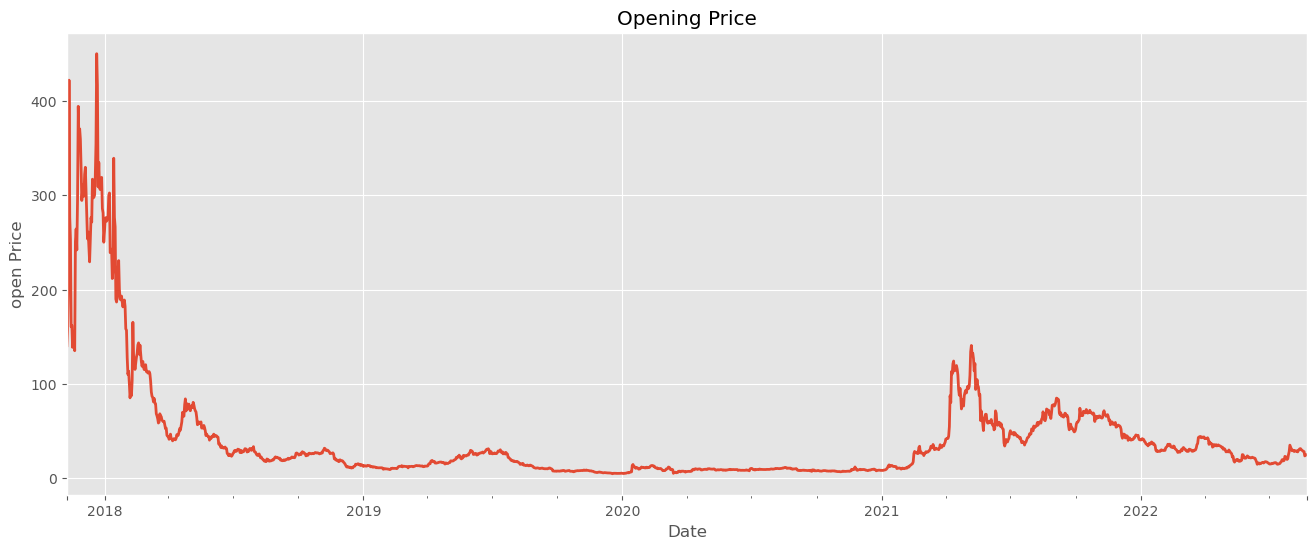

In [12]:
df['Open'].plot(figsize=(16,6))
plt.ylabel('open Price')
plt.title('Opening Price')

Text(0.5, 1.0, 'High Price')

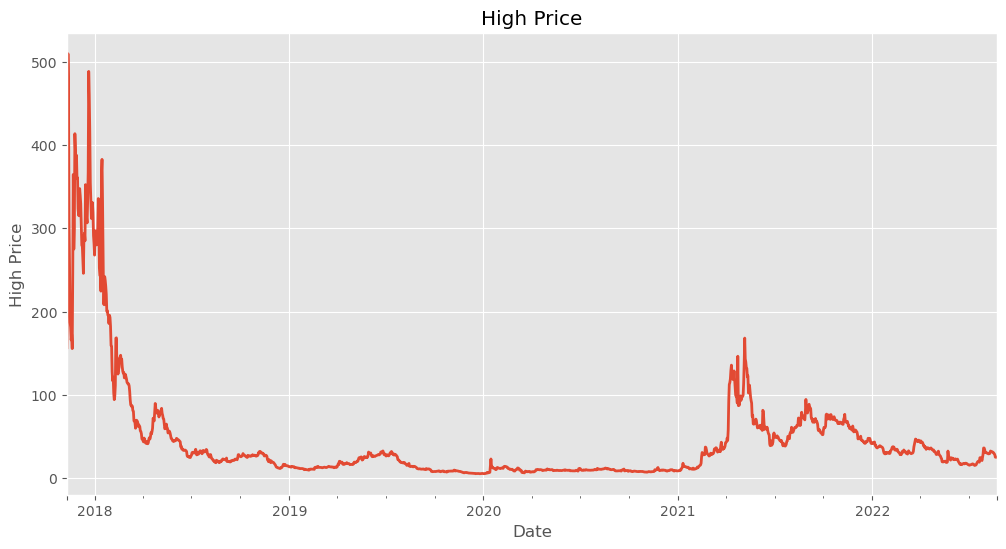

In [13]:
df['High'].plot(figsize=(12,6))
plt.ylabel('High Price')
plt.title('High Price')

Text(0.5, 1.0, 'Low Price')

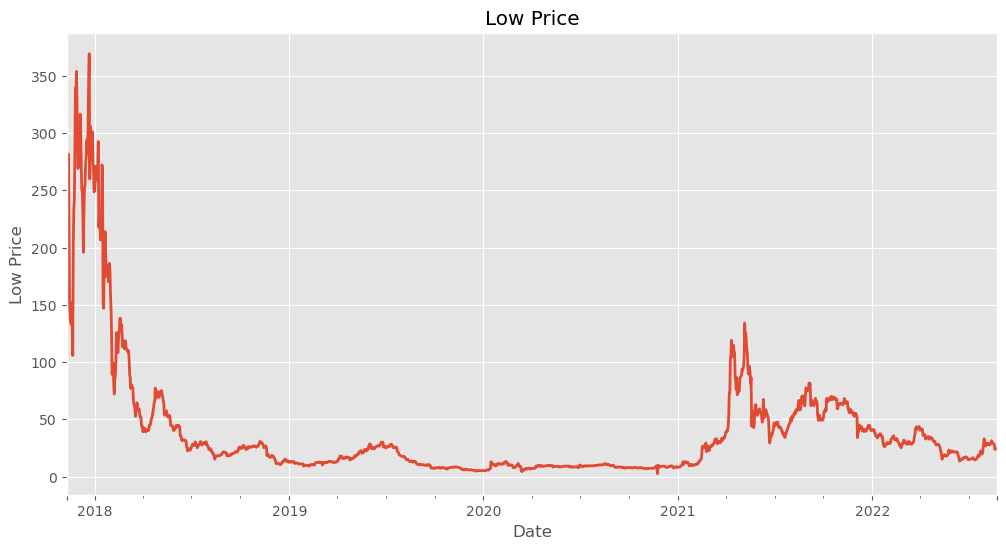

In [14]:
df['Low'].plot(figsize=(12,6))
plt.ylabel('Low Price')
plt.title('Low Price')

Text(0.5, 1.0, 'Closing Price')

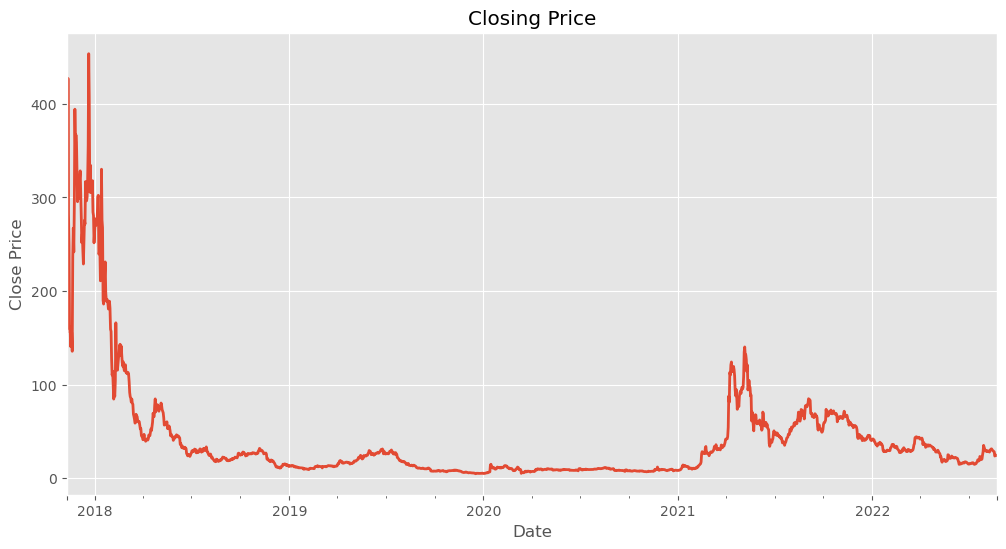

In [15]:
df['Close'].plot(figsize=(12,6))
plt.ylabel('Close Price')
plt.title('Closing Price')

Text(0.5, 1.0, 'Volume Price')

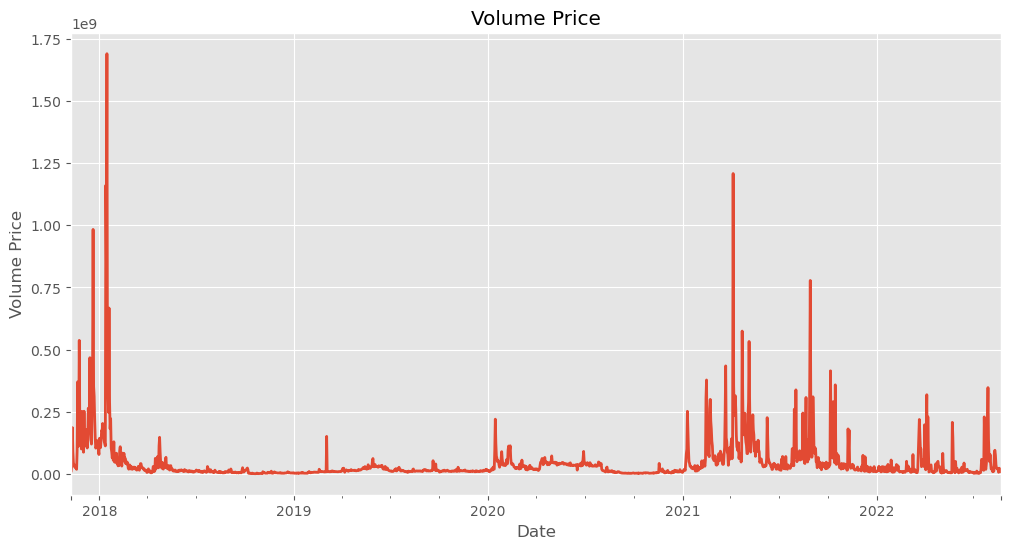

In [16]:
df['Volume'].plot(figsize=(12,6))
plt.ylabel('Volume Price')
plt.title('Volume Price')

In [17]:
# total portfolio value
df['Total Pov'] = df.sum(axis=1)

Text(0.5, 1.0, 'Total Portfolio Value')

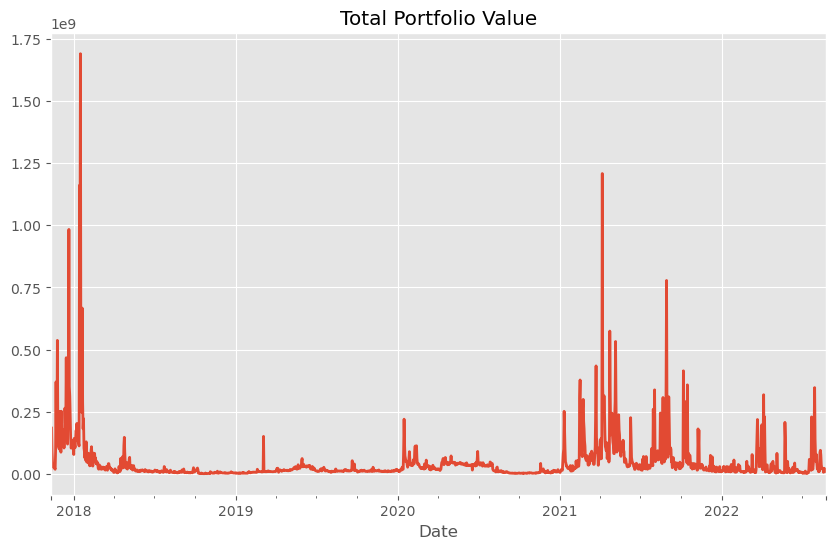

In [18]:
df['Total Pov'].plot(figsize=(10,6))
plt.title('Total Portfolio Value')

In [19]:
# daily return
df['Daily Return'] = df['Total Pov'].pct_change(1)

In [20]:
df['Daily Return'].mean()

0.1860581918370679

<AxesSubplot:ylabel='Density'>

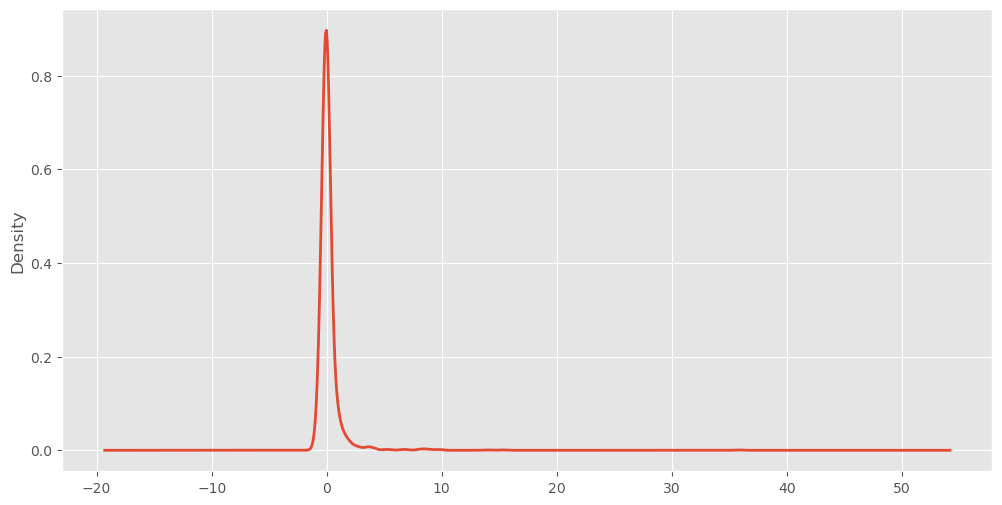

In [21]:
df['Daily Return'].plot(kind='kde', figsize=(12,6))

In [22]:
# data votality
SR = df['Daily Return'].mean()/df['Daily Return'].std()
SR

0.13795630639848022

In [23]:
df = df.drop('Currency', axis=1)

<AxesSubplot:xlabel='Date'>

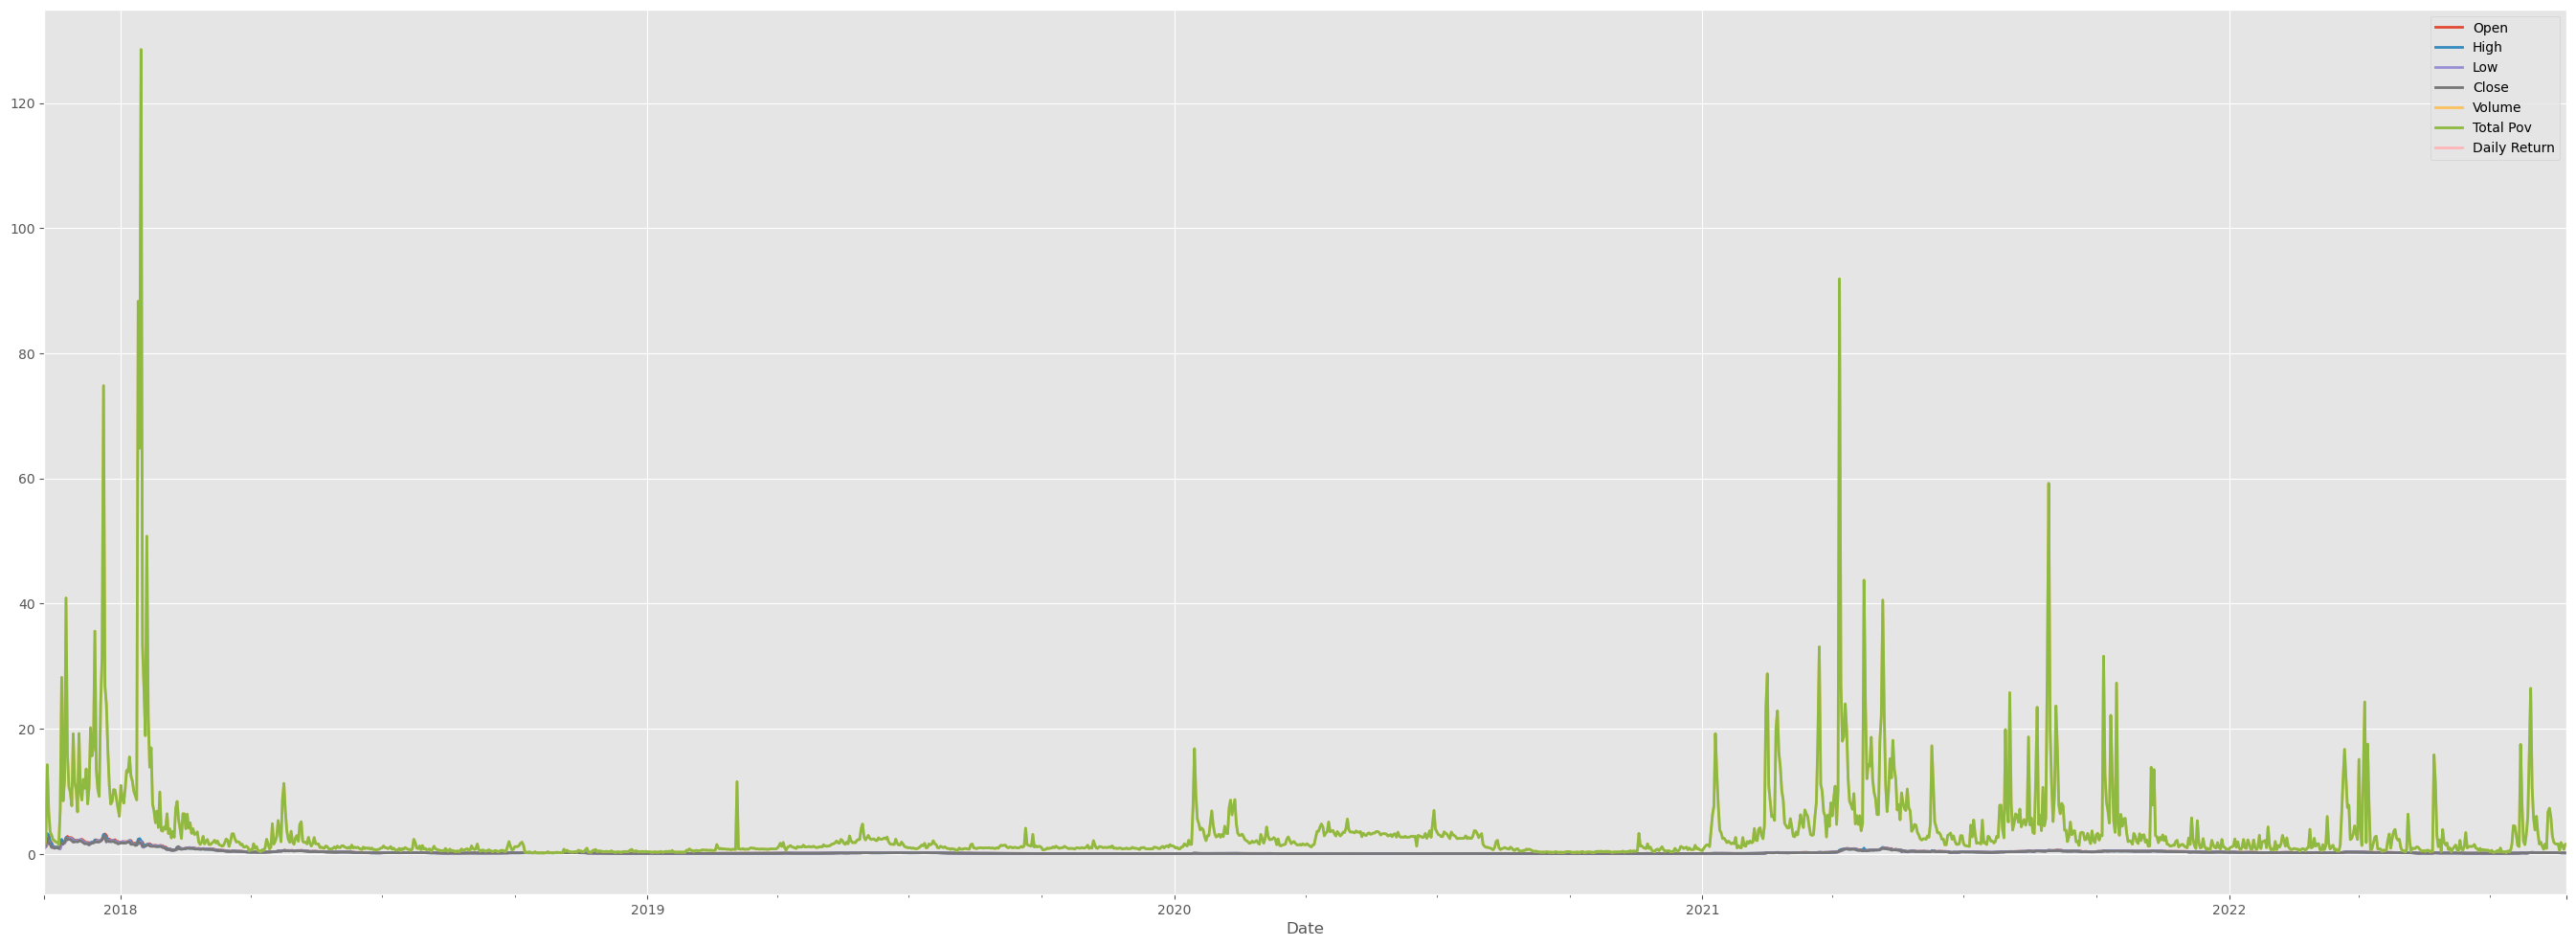

In [24]:
all_plt = df/df.iloc[0]
all_plt.plot(figsize=(34,12))

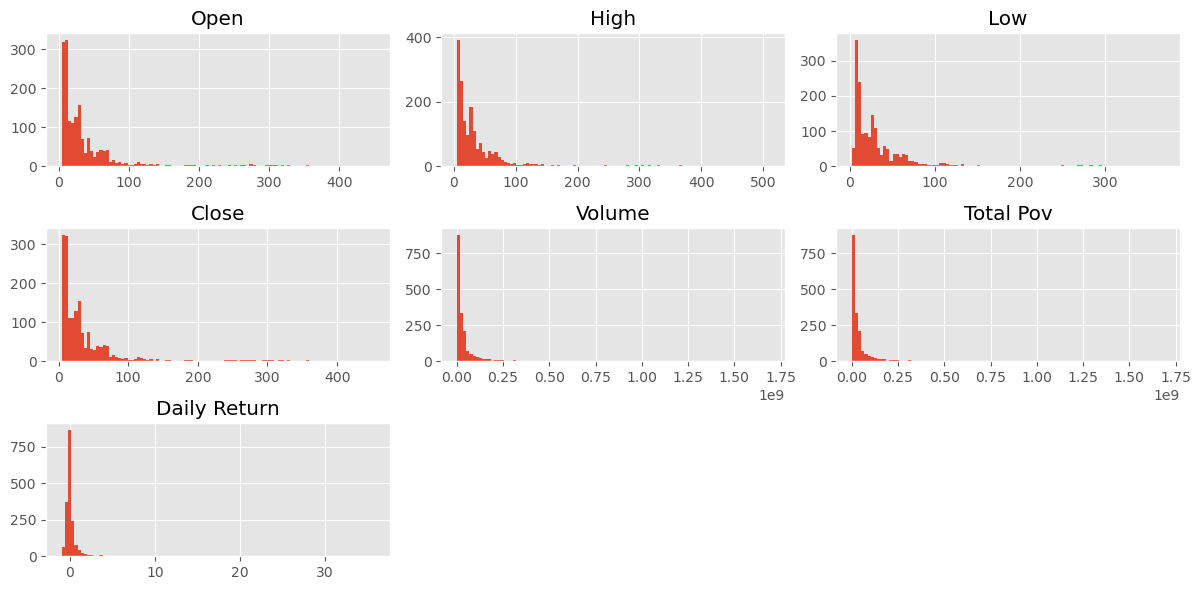

In [25]:
#3. histograms
df.hist(bins=100, figsize=(12,6));
plt.tight_layout()

In [26]:
df.resample(rule='A').mean()

Open        High         Low       Close        Volume  \
Date                                                                       
2017-12-31  281.447679  313.479679  254.968303  283.300849  1.761246e+08   
2018-12-31   59.504325   62.859098   55.585332   58.804762  3.911406e+07   
2019-12-31   14.440855   14.924827   13.989406   14.419816  1.499623e+07   
2020-12-31    9.096205    9.479982    8.749003    9.103864  2.681281e+07   
2021-12-31   53.584517   56.959785   50.620845   53.654878  8.439958e+07   
2022-12-31   28.246711   29.270079   27.332272   28.176719  3.234718e+07   

               Total Pov  Daily Return  
Date                                    
2017-12-31  1.761257e+08      0.317471  
2018-12-31  3.911429e+07      0.099900  
2019-12-31  1.499629e+07      0.068253  
2020-12-31  2.681284e+07      0.047344  
2021-12-31  8.439980e+07      0.268765  
2022-12-31  3.234729e+07      0.561354

In [ ]:
# yearly mean

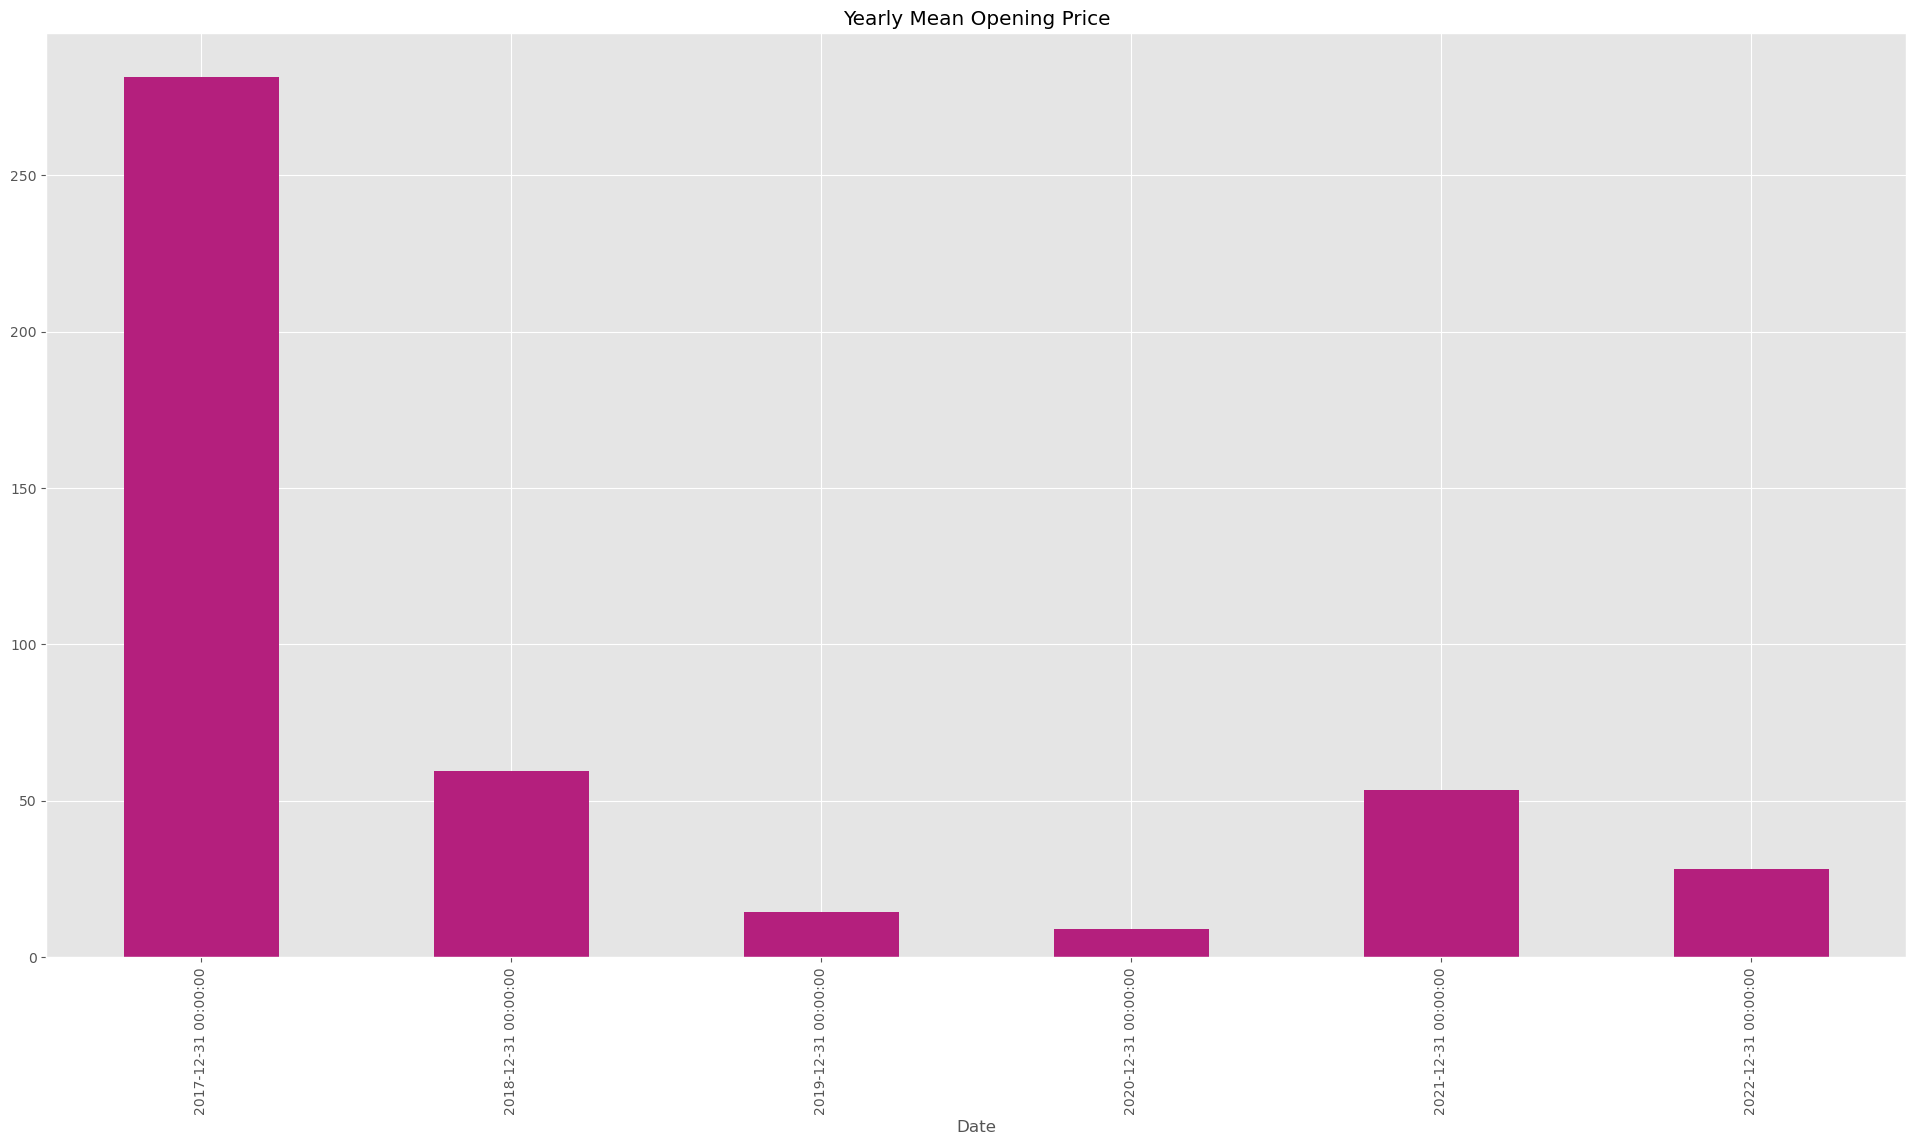

In [27]:
df['Open'].resample(rule='A').mean().plot.bar(title='Yearly Mean Opening Price', color=['#b41f7d'], figsize=(24,12));

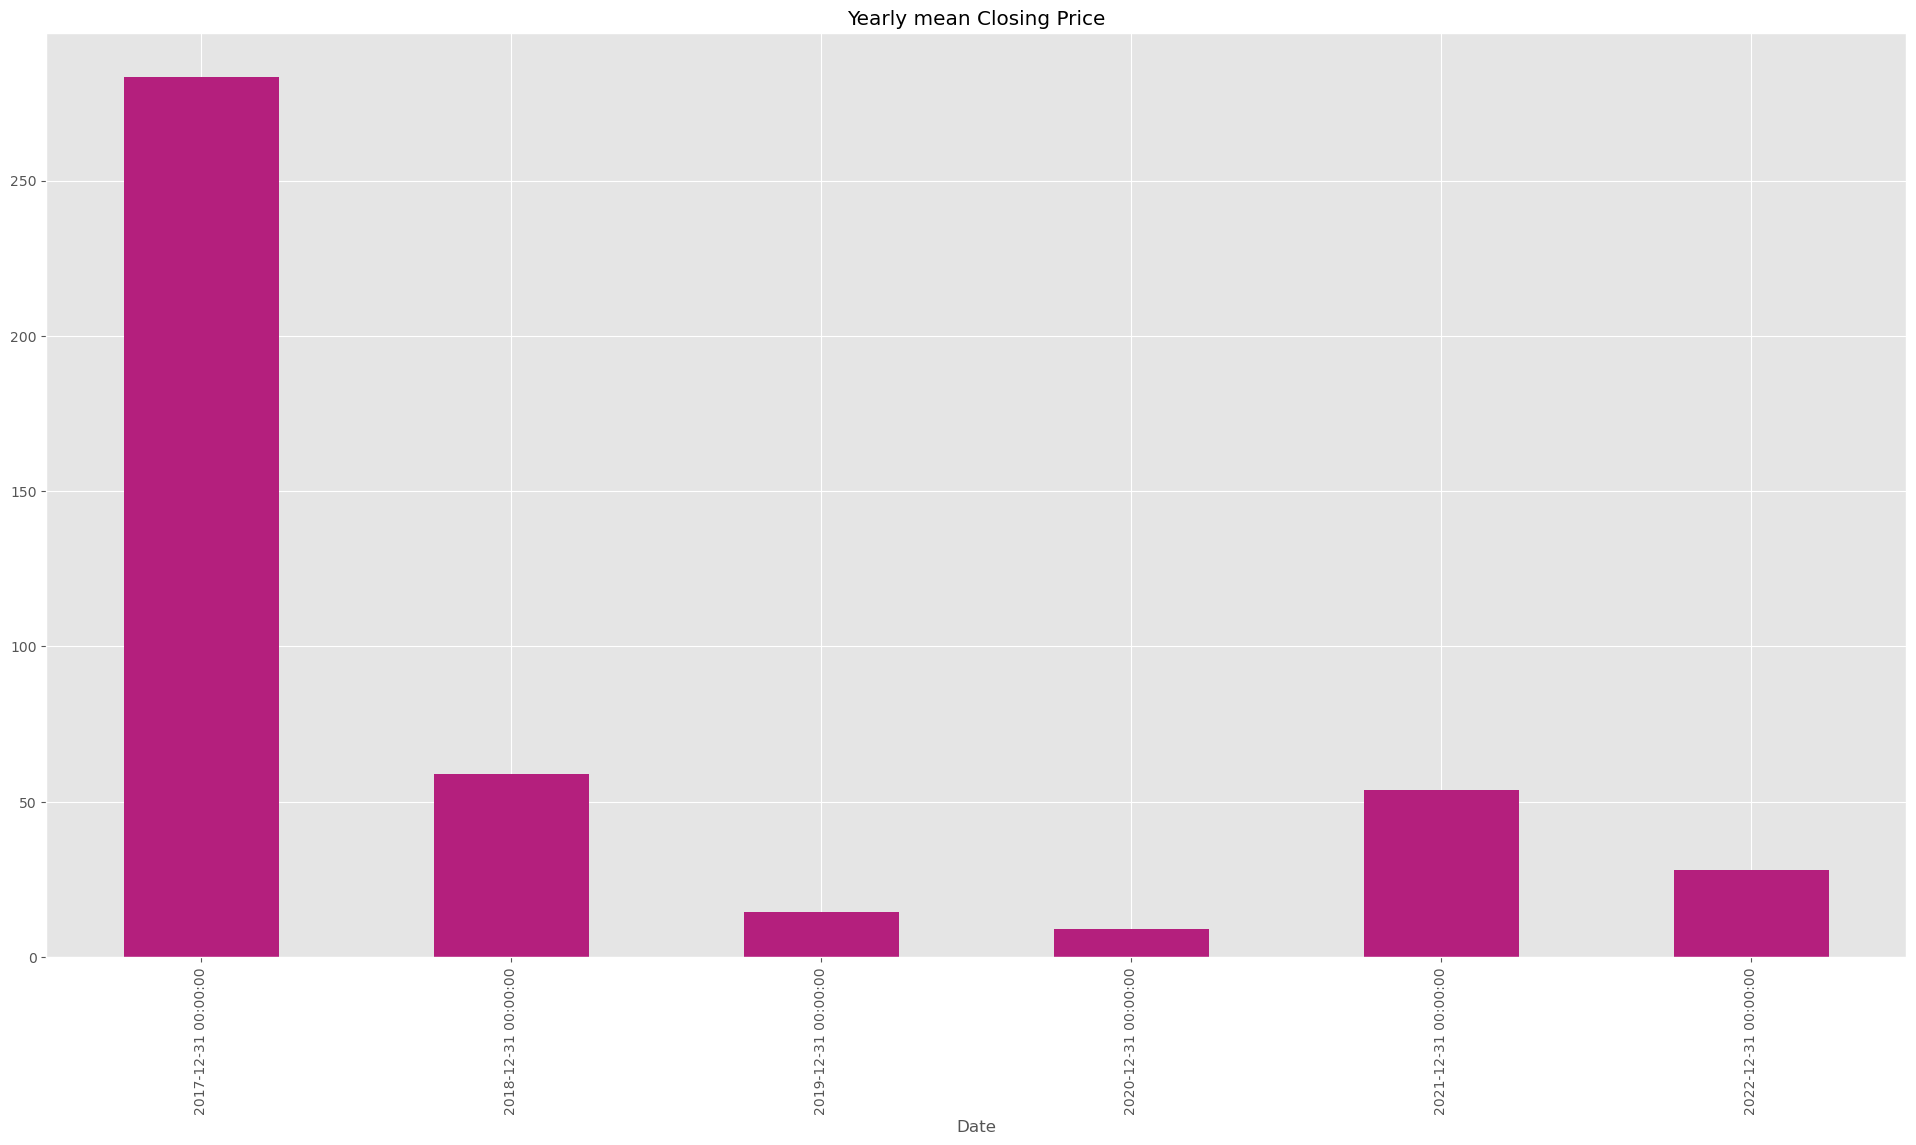

In [28]:
df['Close'].resample(rule='A').mean().plot.bar(title='Yearly mean Closing Price', color=['#b41f7d'],  figsize=(24,12));

In [29]:
# determining the best Simple Moving average
df['6-month-SMA']  = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA']  = df['Open'].rolling(window=2).mean()
df['1-month-SMA']  = df['Open'].rolling(window=1).mean()

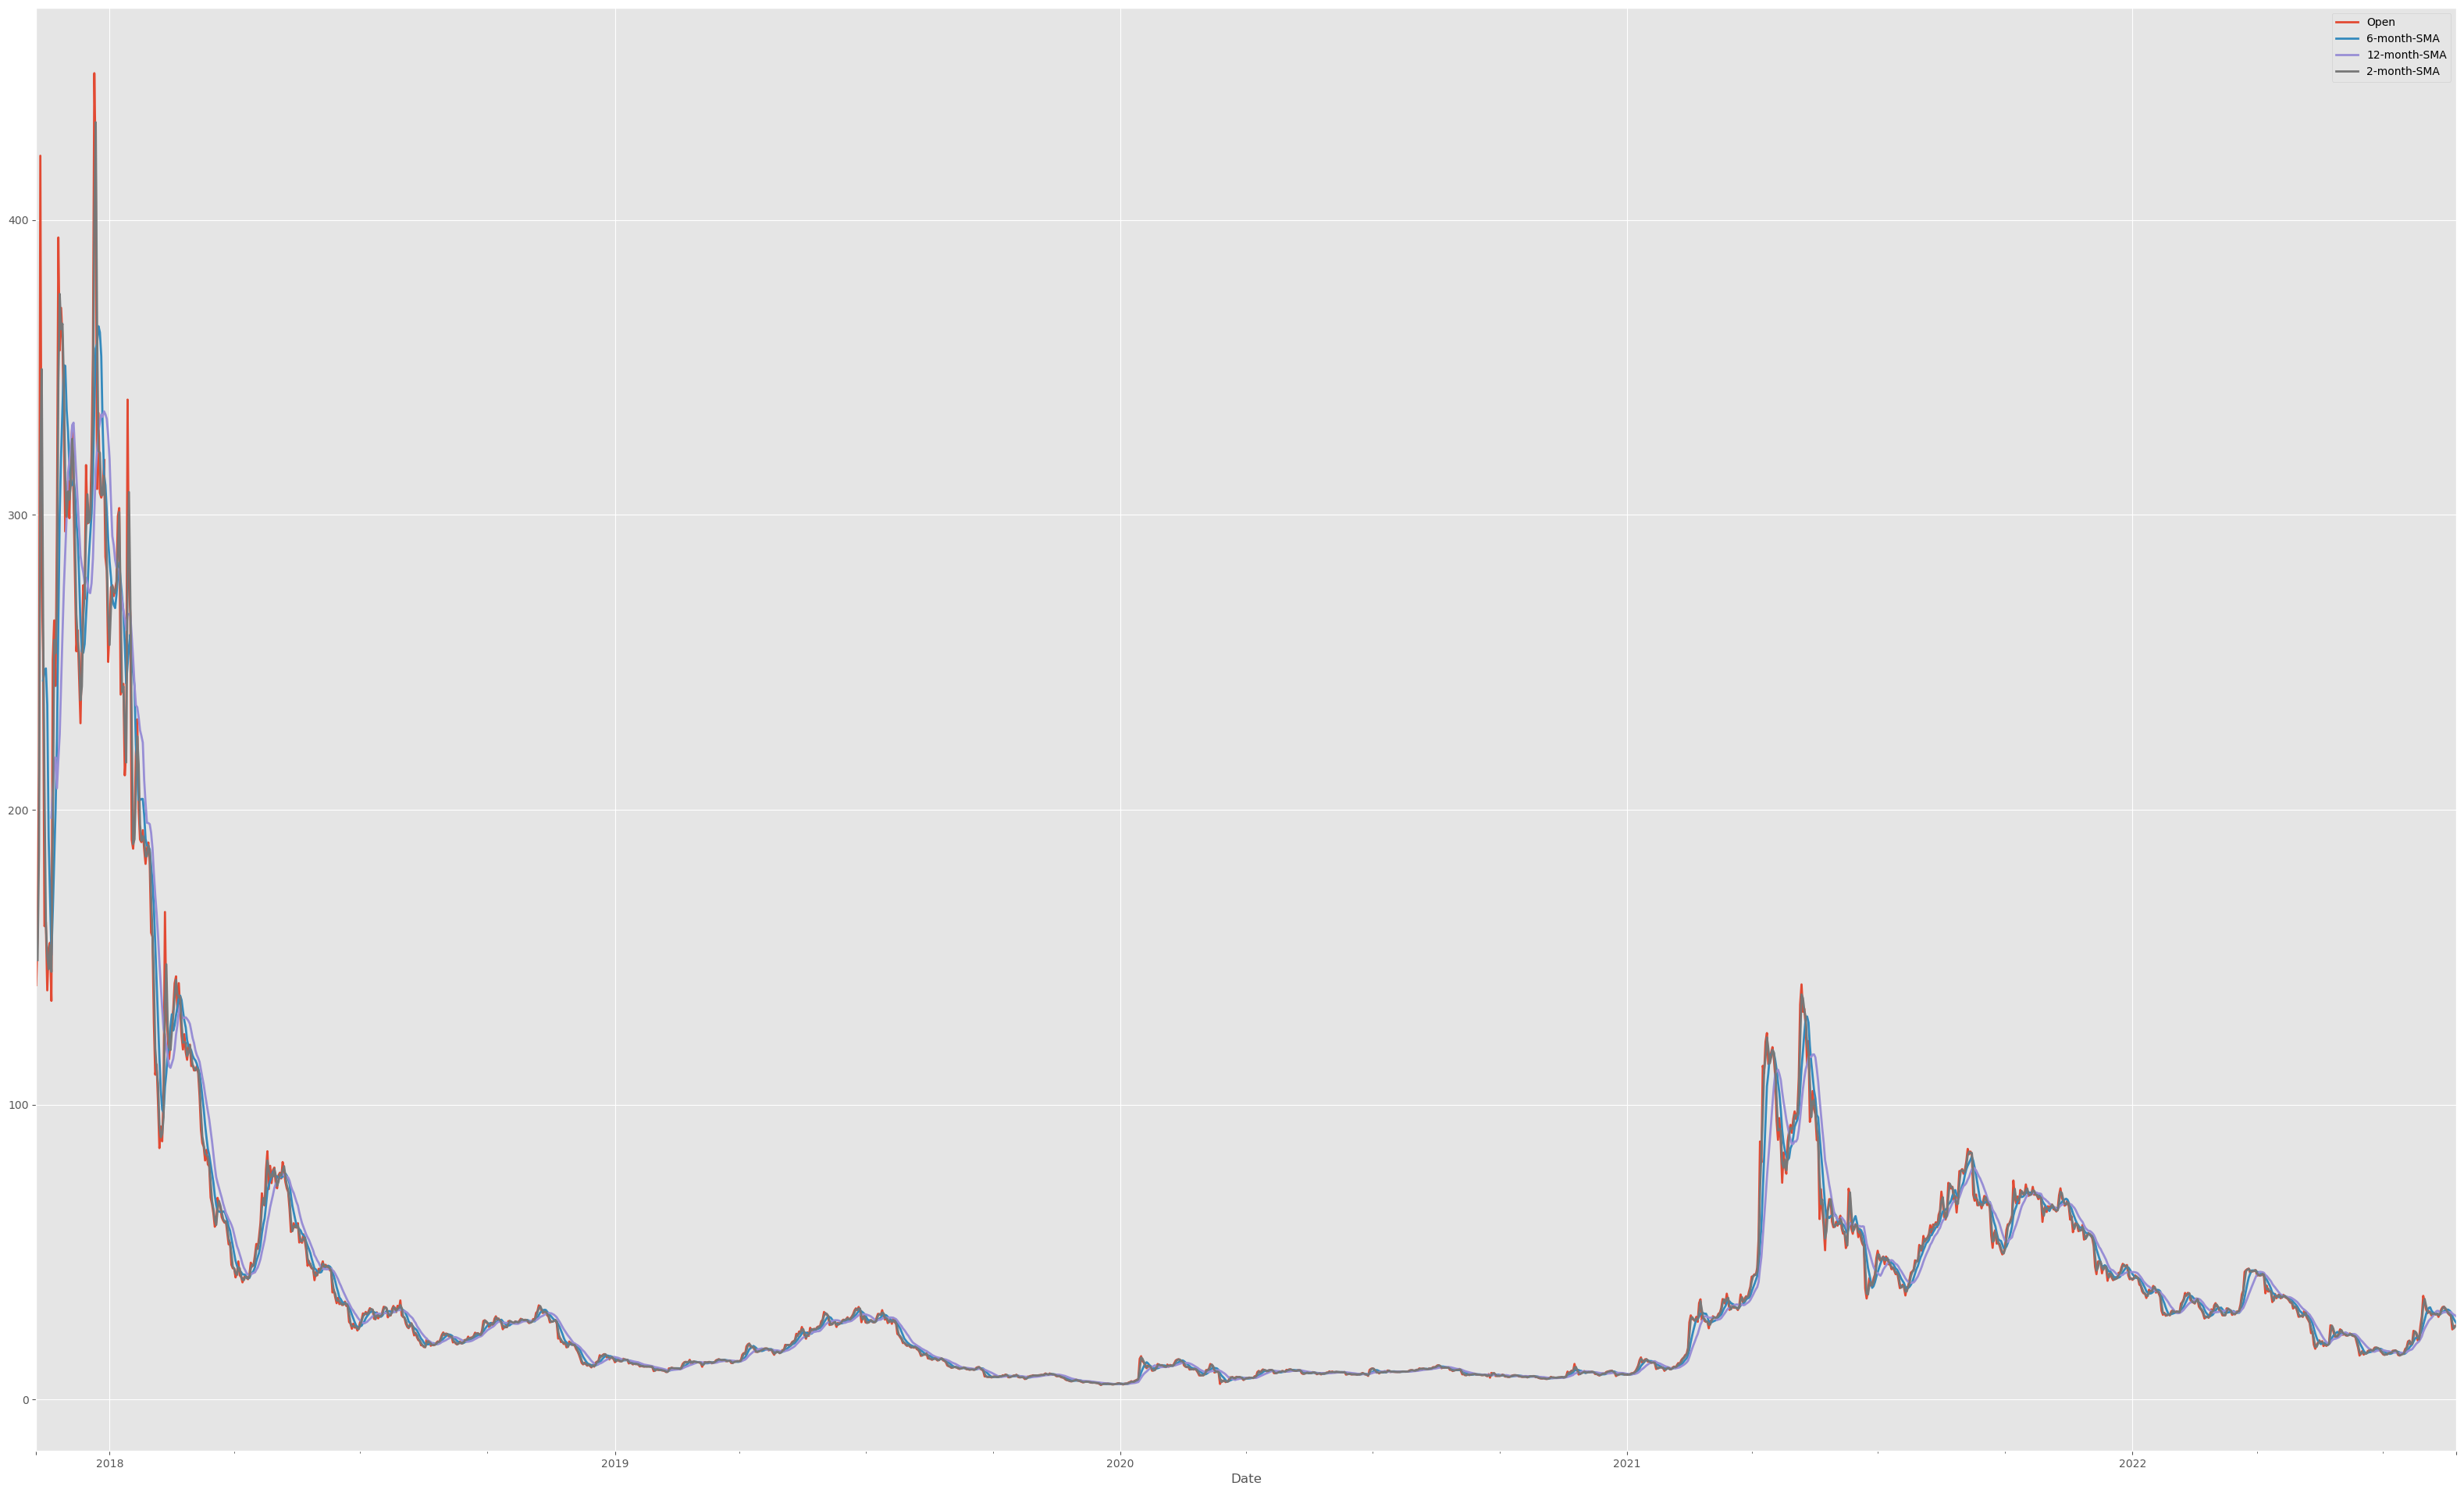

In [30]:
df[['Open', '6-month-SMA', '12-month-SMA', '2-month-SMA']].plot(figsize=(40,24));

<AxesSubplot:xlabel='Date'>

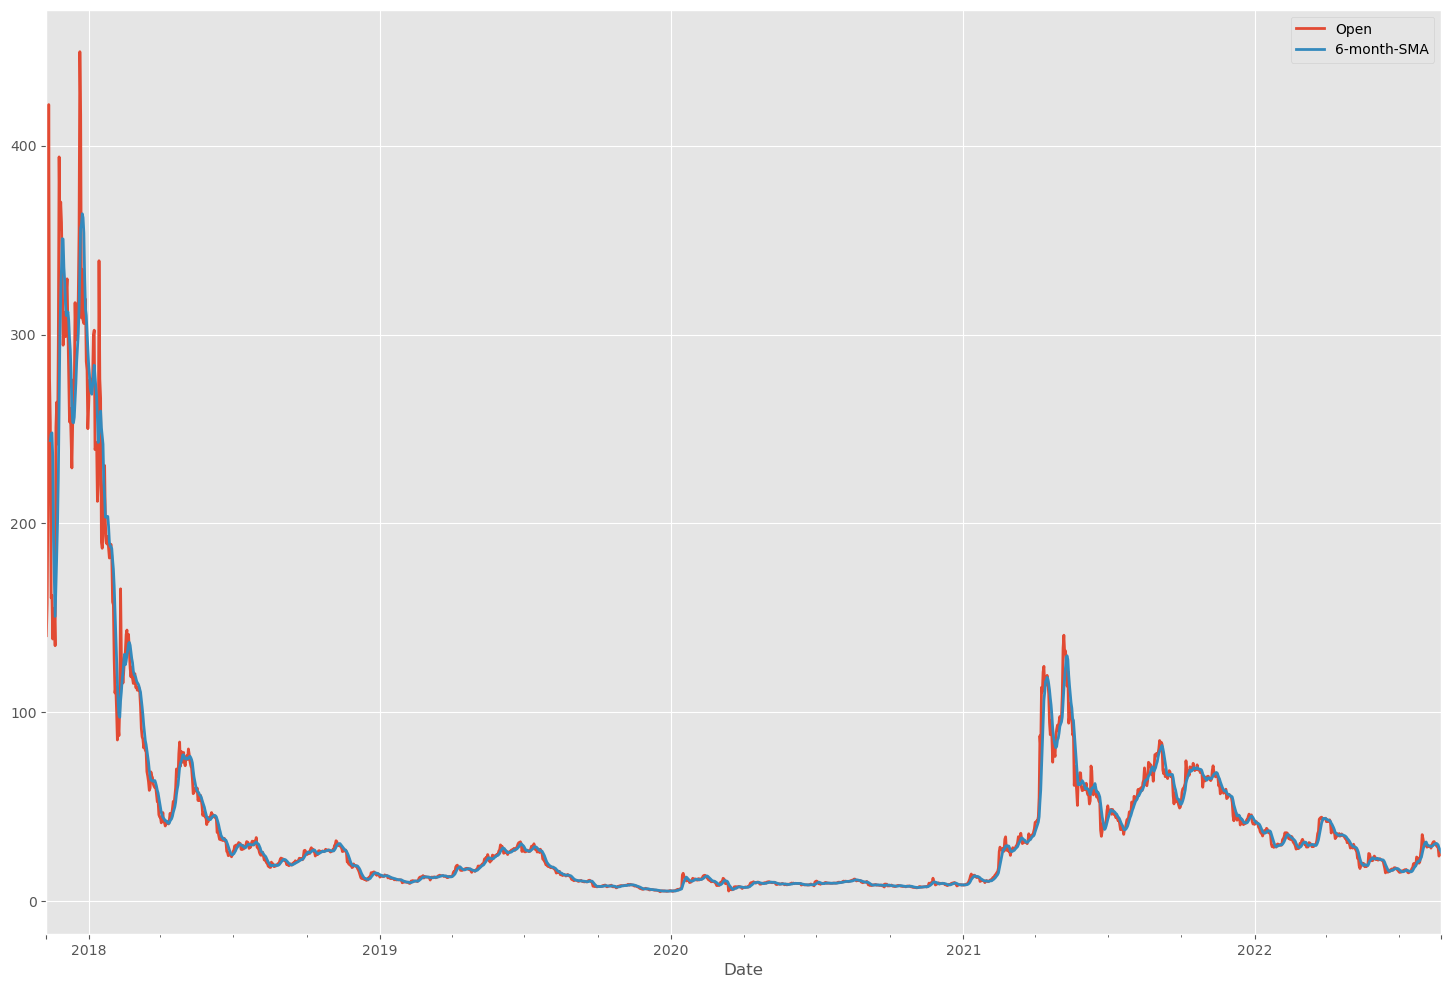

In [31]:
df[['Open','6-month-SMA']].plot(figsize=(18,12))

<AxesSubplot:xlabel='Date'>

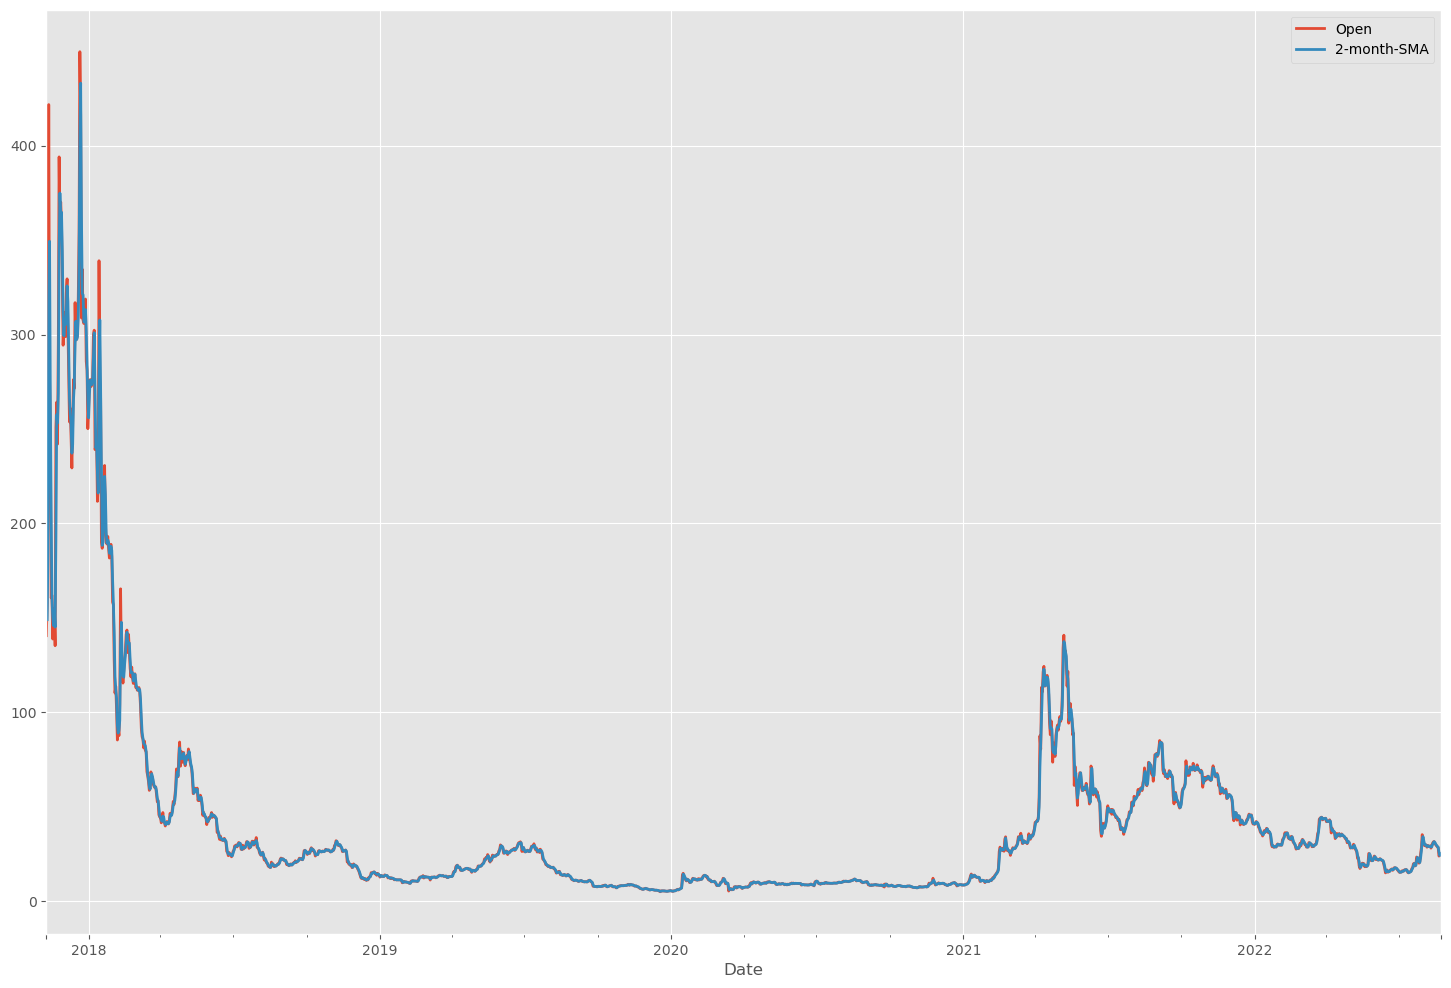

In [32]:
df[['Open','2-month-SMA']].plot(figsize=(18,12))

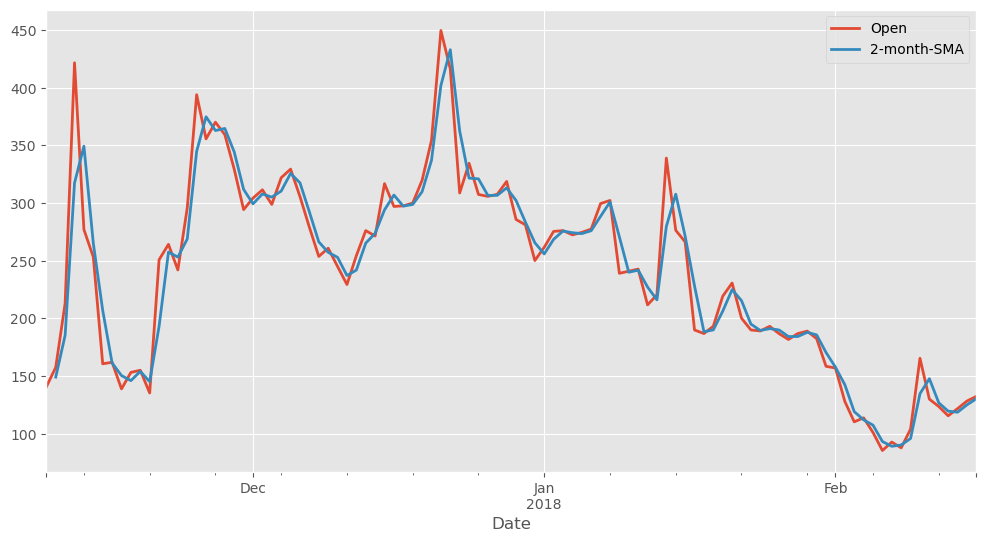

In [33]:
df[['Open', '2-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

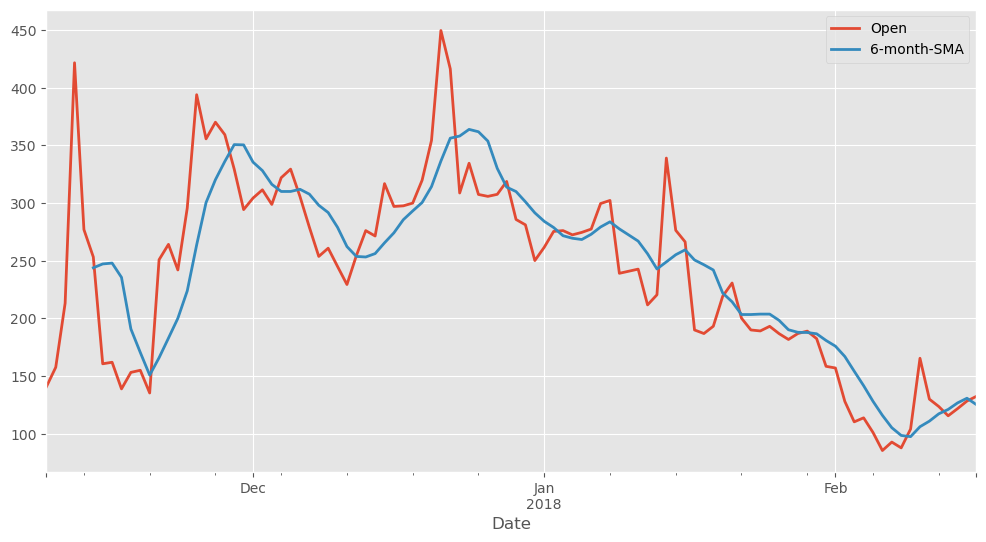

In [34]:
df[['Open', '6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [35]:
# exponential moving average/ smoothing
df['EWM-A12'] = df['Open'].ewm(span=14, adjust=True).mean()

In [36]:
span = 8
alpha = 2/(span+1)

In [37]:
df['EWM-A12'] = df['Open'].ewm(alpha=alpha, adjust= False).mean()

In [39]:

model = SimpleExpSmoothing(df['Open'])

In [40]:
fitted_model = model.fit(smoothing_level = alpha, optimized = False)

In [41]:
#df[['Open', 'EWM-A12']].plot(figsize=(24,12));
fitted_model.fittedvalues

Date
2017-11-09    140.514008
2017-11-10    140.514008
2017-11-11    144.286452
2017-11-12    159.583683
2017-11-13    217.842865
                 ...    
2022-08-19     29.639007
2022-08-20     29.350887
2022-08-21     28.115179
2022-08-22     27.297107
2022-08-23     26.793639
Freq: D, Length: 1749, dtype: float64

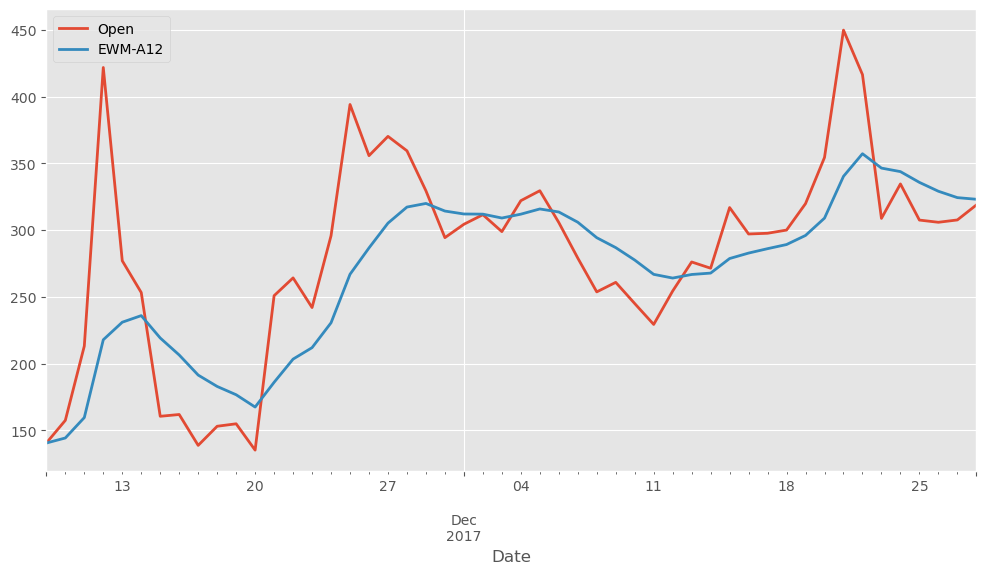

In [42]:
df[['Open','EWM-A12']].iloc[:50].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

<AxesSubplot:>

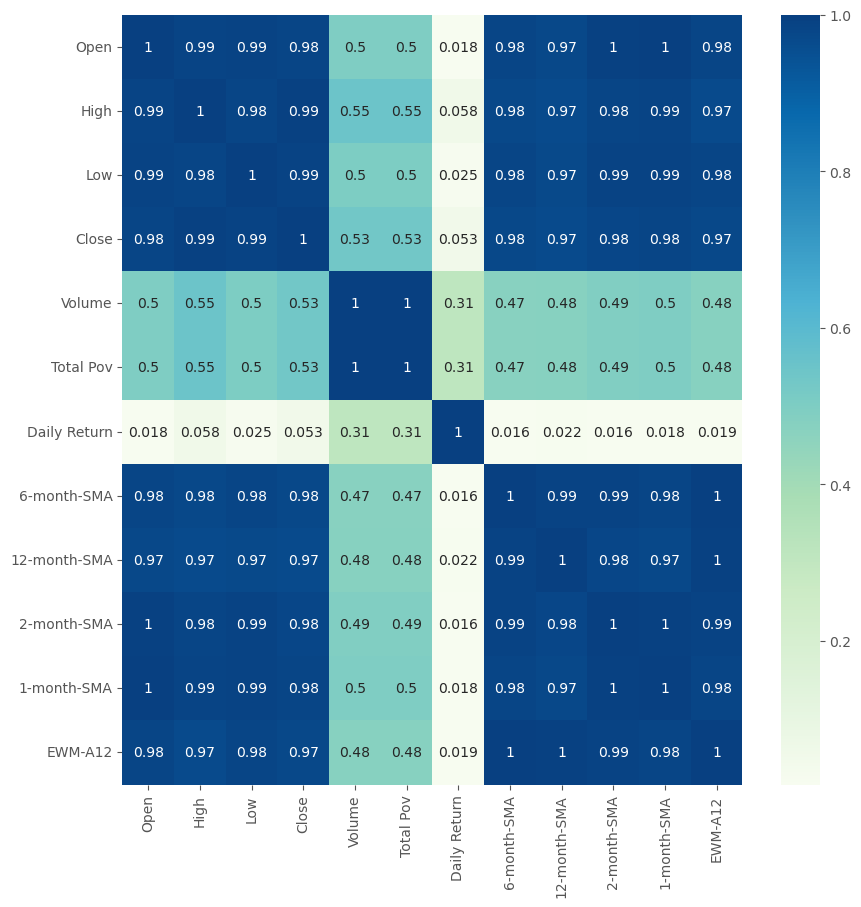

In [91]:
# correlation plot
sns.heatmap(df.corr(),
            annot=True,cmap="GnBu")

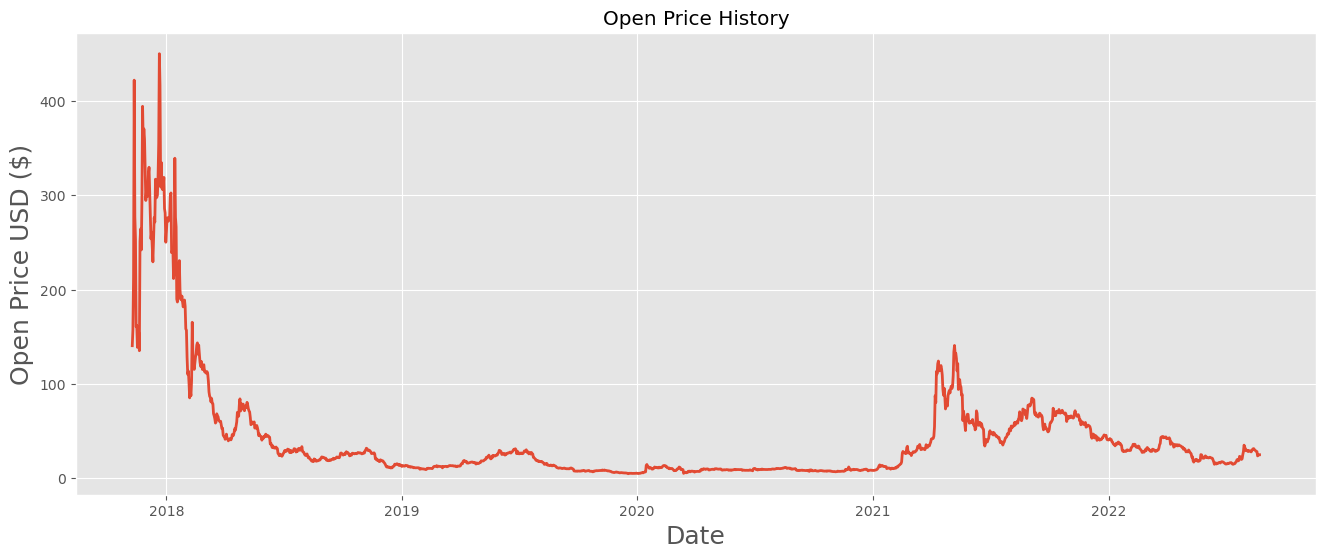

In [43]:
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# LSTM MODEL

In [44]:
#determining train set length
data = df.filter(['Open'])
dataset = data.values
training_data_len = int(np.ceil (len(dataset) * .80))
training_data_len

1400

In [45]:
#normalizing scale 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
scaled_data.shape

(1749, 1)

In [46]:
train_data = scaled_data[0:int(training_data_len), :]

X_train = []
Y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])
    if i<= 61:
        print(X_train)
        print(Y_train)
        print()
        
X_train, Y_train = np.array(X_train), np.array(Y_train)
x_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[array([0.30480955, 0.34297362, 0.46804547, 0.93706164, 0.61165309,
       0.55817483, 0.34982813, 0.35282486, 0.30084612, 0.33304143,
       0.33718469, 0.2928563 , 0.55286028, 0.58282998, 0.53289697,
       0.65380532, 0.874773  , 0.78862278, 0.82112165, 0.79679026,
       0.72945679, 0.65060405, 0.67310321, 0.68922672, 0.66074528,
       0.7128387 , 0.72960519, 0.67607075, 0.61620778, 0.55928092,
       0.57532347, 0.53965035, 0.50446953, 0.56073319, 0.6096455 ,
       0.59911986, 0.70127441, 0.65675262, 0.65797108, 0.66334858,
       0.70788389, 0.78559686, 1.        , 0.92511515, 0.68303767,
       0.74102561, 0.68018251, 0.67646641, 0.68040734, 0.70557951,
       0.63136234, 0.62089962, 0.55121467, 0.57708825, 0.60808311,
       0.60967027, 0.60137697, 0.60620815, 0.61265351, 0.66244708])]
[0.6684833452974392]

[array([0.30480955, 0.34297362, 0.46804547, 0.93706164, 0.61165309,
       0.55817483, 0.34982813, 0.35282486, 0.30084612, 0.33304143,
       0.33718469, 0.2928563 , 0.552

In [47]:
X_train.shape

(1340, 60)

In [48]:
Y_train.shape

(1340,)

In [49]:
x_train.shape

(1340, 60, 1)

In [50]:
test_data = scaled_data[training_data_len - 60: , :]
X_test = []
Y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60: i, 0])
    
X_test = np.array(X_test)
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [51]:
X_test.shape


(349, 60)

In [52]:
x_test.shape

(349, 60, 1)

In [ ]:
model = Sequential()
model.add(LSTM(63, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(56, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')

model.summary()

In [ ]:
callbacks = [EarlyStopping(patience=4, monitor='loss', mode='min'),]

In [ ]:
history = model.fit(x_train, y_train,epochs=50, batch_size=32)

from keras.models import load_model
model.save('LSTM.h5')
del model    

from keras.models import load_model
model = load_model('LSTM.h5')

In [54]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

preds = model.predict(x_test)
preds = scaler.inverse_transform(preds)

rmse = np.sqrt(np.mean(((preds - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds))

11/11 [==============================] - 3s 31ms/step
Root Mean Squared Error 2.5178045149537476
Mean Absolute Error 1.9149006075708777


In [56]:
y_test.max(), y_test.min()

(74.27957153320312, 14.920206069946287)

In [57]:
get_mape(y_test, preds)

5.778214153828982

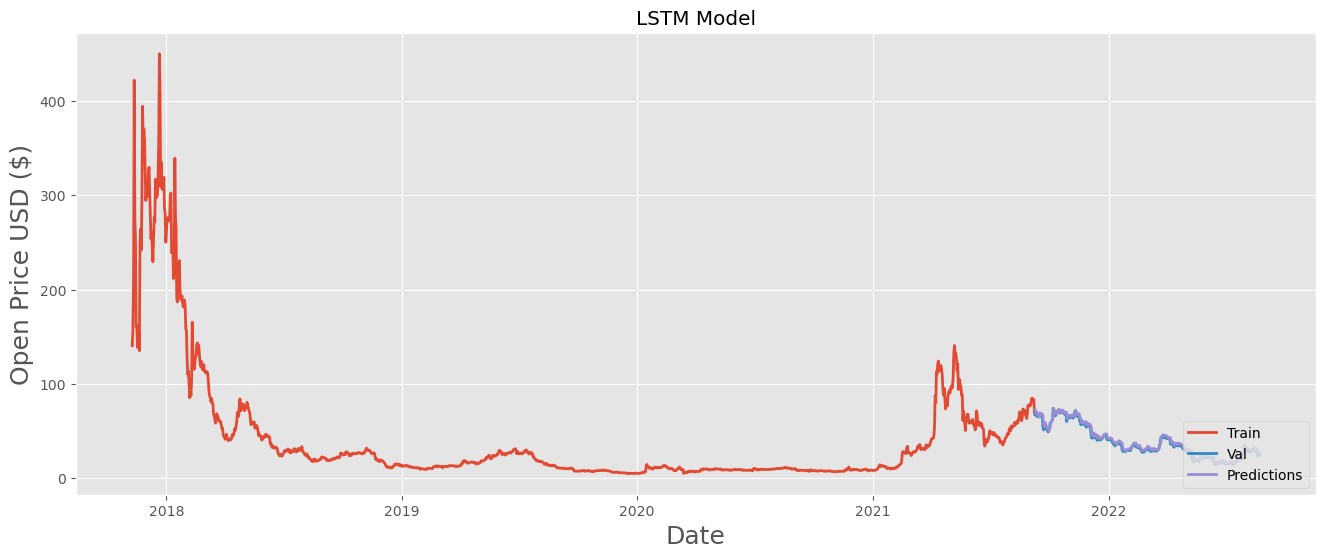

In [58]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

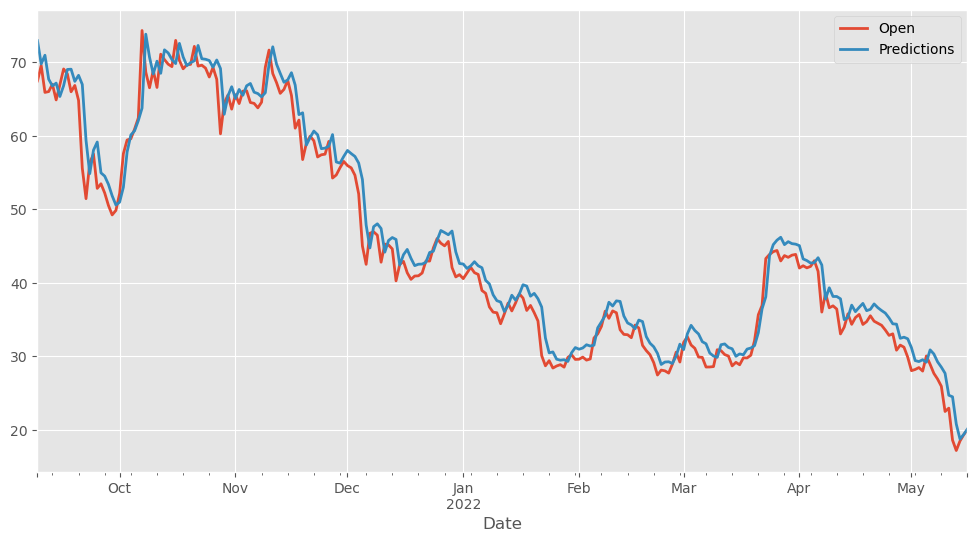

In [59]:
valid[['Open', 'Predictions']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

# Gated Recurrent Unit (GRU)

In [ ]:
model2 = Sequential()
model2.add(GRU(63, return_sequences=True, input_shape=(x_train.shape[1],1)))
model2.add(GRU(55, return_sequences=False))
#model2.add(Dense(54))
model2.add(Dense(16))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(optimizer='rmsprop', loss='mean_squared_error',metrics='mean_squared_error')
model2.summary()

#model2.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mae','mse'])



In [ ]:
callbacks = [EarlyStopping(patience=3, monitor='loss', mode='min'),]

In [ ]:
model2.fit(x_train, y_train, epochs=50, batch_size=15,)

from keras.models import load_model
model2.save('GRU.h5')
del model2    

model2 = load_model('GRU.h5')

In [61]:
preds_gru = model2.predict(x_test)
preds_gru = scaler.inverse_transform(preds_gru)

rmse = np.sqrt(np.mean(((preds_gru - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds_gru))

11/11 [==============================] - 2s 28ms/step
Root Mean Squared Error 2.119364486370041
Mean Absolute Error 1.4062385996296618


In [62]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [63]:
get_mape(y_test, preds_gru)

3.9357222868266963

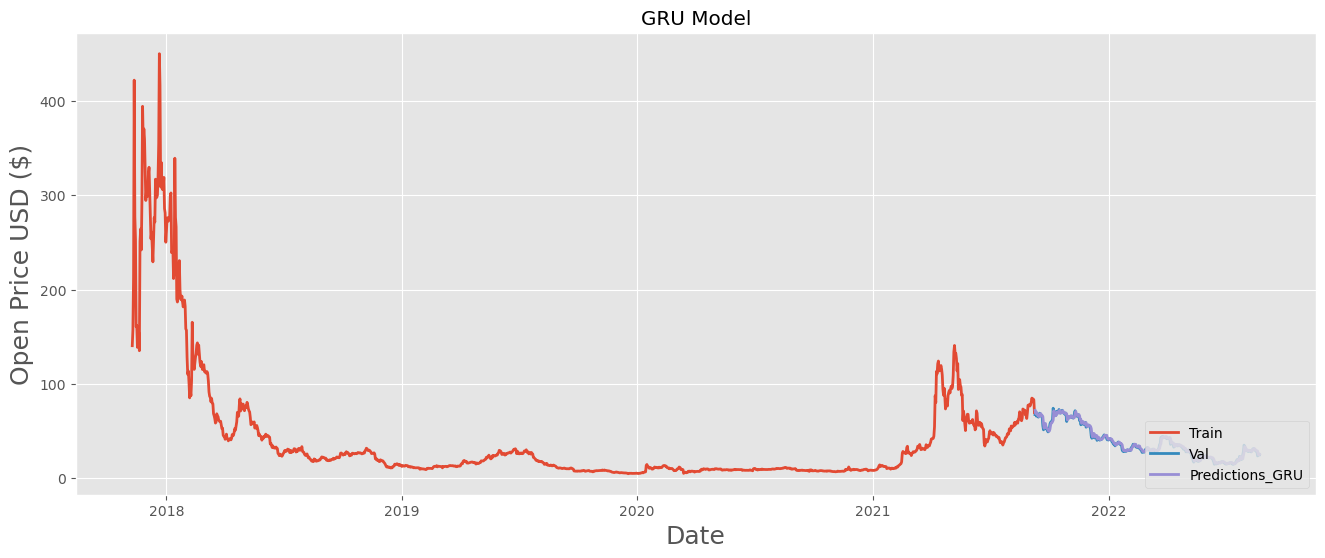

In [64]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_GRU'] = preds_gru

plt.figure(figsize=(16,6))
plt.title('GRU Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions_GRU']])
plt.legend(['Train', 'Val', 'Predictions_GRU'], loc='lower right')
plt.show()

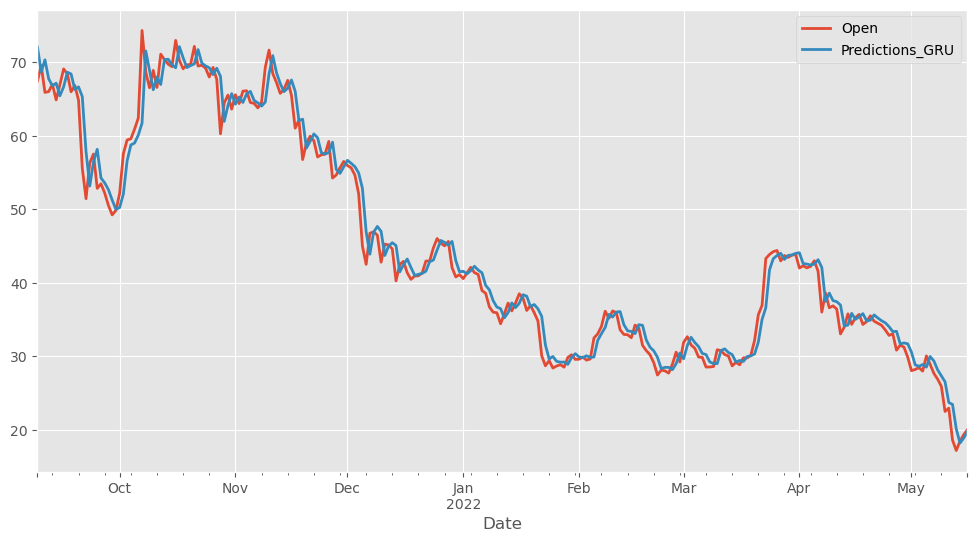

In [65]:
valid[['Open', 'Predictions_GRU']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

In [77]:
from sklearn.ensemble import RandomForestRegressor

RFr = RandomForestRegressor(n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,)
RFr.fit(X_train, Y_train)

RandomForestRegressor()

In [81]:
Y_test_pred = RFr.predict(X_test)
Y_test_pred = Y_test_pred.reshape(-1,1)

In [82]:
Y_test_pred = scaler.inverse_transform(Y_test_pred)

In [83]:
Y_test

array([[67.43177032],
       [69.52471924],
       [65.87470245],
       [65.98371887],
       [66.9868927 ],
       [64.8530426 ],
       [66.91493988],
       [69.05794525],
       [68.38983154],
       [65.95700073],
       [66.8180542 ],
       [64.79402924],
       [55.57976151],
       [51.43900299],
       [56.30630493],
       [57.49858093],
       [52.83366394],
       [53.45998001],
       [52.20889664],
       [50.51939774],
       [49.23148727],
       [49.84349442],
       [52.14902496],
       [57.55282974],
       [59.40578079],
       [59.57663345],
       [60.88661957],
       [62.40465164],
       [74.27957153],
       [68.63401031],
       [66.50410461],
       [68.8663559 ],
       [66.54660034],
       [71.06887817],
       [70.32788849],
       [69.704216  ],
       [69.37456512],
       [72.94023132],
       [70.21761322],
       [69.0824585 ],
       [69.61565399],
       [69.6818161 ],
       [72.12641144],
       [69.44778442],
       [69.57022858],
       [69

In [84]:
Y_test_pred 

array([[68.65318909],
       [66.10260925],
       [67.62125393],
       [64.53006798],
       [64.87808899],
       [64.6637299 ],
       [63.48361435],
       [64.48735695],
       [64.4566206 ],
       [64.11901962],
       [63.74820118],
       [63.79767174],
       [63.37172104],
       [57.63441593],
       [52.94813858],
       [56.66826809],
       [56.74513653],
       [53.9698156 ],
       [53.29752243],
       [52.3039909 ],
       [47.94156288],
       [47.41106697],
       [48.43898003],
       [51.19013634],
       [56.97666183],
       [57.79575066],
       [58.29391804],
       [61.23768017],
       [62.72829315],
       [75.3259967 ],
       [65.79917156],
       [65.43528698],
       [65.51722919],
       [64.91902748],
       [67.95254982],
       [66.85976669],
       [67.14411015],
       [67.11514076],
       [73.68917408],
       [67.80644764],
       [66.01776016],
       [67.14824768],
       [66.67587776],
       [73.51893497],
       [66.90308296],
       [66

In [85]:
get_mape(Y_test, Y_test_pred)

4.295207718268549

In [86]:
rmse = np.sqrt(np.mean(((Y_test_pred  - Y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(Y_test, Y_test_pred))

Root Mean Squared Error 2.3232363605418356
Mean Absolute Error 1.6267919136801543


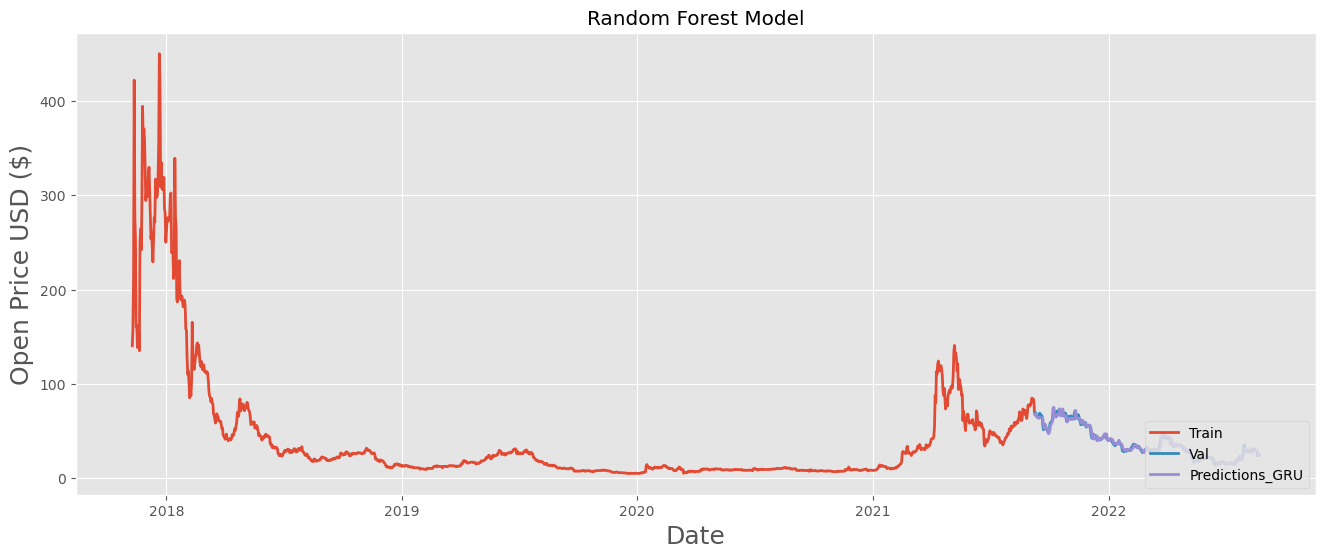

In [89]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_Random'] = Y_test_pred

plt.figure(figsize=(16,6))
plt.title('Random Forest Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions_Random']])
plt.legend(['Train', 'Val', 'Predictions_GRU'], loc='lower right')
plt.show()

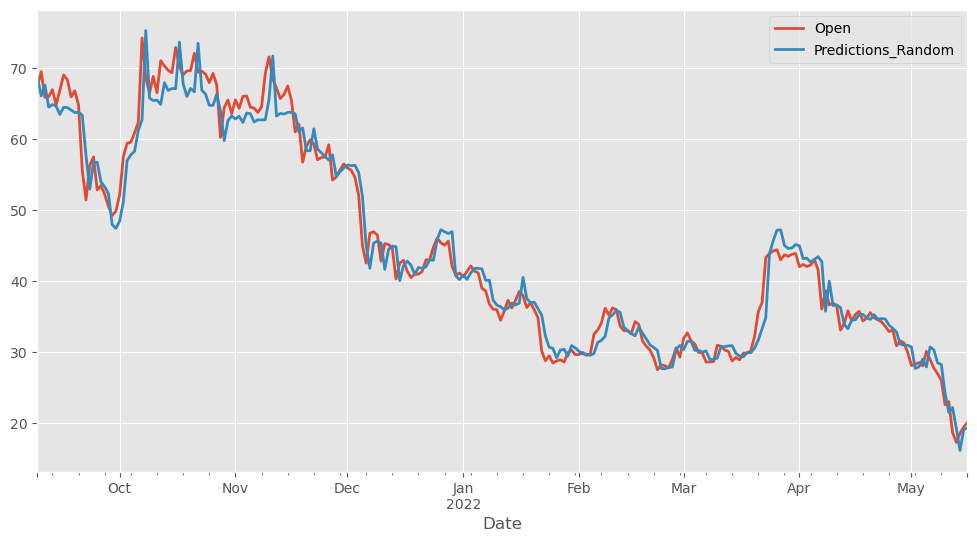

In [90]:
valid[['Open', 'Predictions_Random']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);